# Chapter 2

Example project end to end.

# TOC

1. [Accessing Real Data](#real_data)
2. [Used Data](#used_data)
3. Project
   1. [Looking at the big picture](#big_picture)
   2. Get the data.
   3. Discover and visualize the data to gain insights.
   4. Prepare the data for Machine Learning algorithms.
   5. Select a model and train it.
   6. Fine-tune your model.
   7. Present your solution.
   8. Launch, monitor, and maintain your system.

<a id='real_data'></a>
## 1. Accessing Real Data

**Popular open data repositories**

* [UC Irvine Machine Learning Repository](http://archive.ics.uci.edu/ml/)
* [Kaggle datasets](https://www.kaggle.com/datasets)
* [Amazon’s AWS datasets](http://aws.amazon.com/fr/datasets/)

**Meta portals** (they list open data repositories)

* http://dataportals.org/
* http://opendatamonitor.eu/
* http://quandl.com/

**Other pages listing many popular open data repositories**

* [Wikipedia’s list of Machine Learning datasets](https://goo.gl/SJHN2k)
* [Quora.com question](http://goo.gl/zDR78y)
* [Datasets subreddit](https://www.reddit.com/r/datasets)

<a id='used_data'></a>
## 2. Used Data

California Housing Prices dataset from the StatLib repository<br />
<img src="images/C02_california_real_state_dataset.png" style="width: 500px" />

# 3. Project

<a id='big_picture'></a>
## 3.A Looking at the big picture

Build a model of housing prices in California using the California census data.

Metrics in this dataset:
* Population
* Median income
* Median housing price
* etc.

Block groups (or **'Districts'**):  smalles geographical unit for which there is sample data. Typically, with a population of 600 to 3000 people.

The model **should learn** from this data and **be able to predict the median housing price in every district**, given all other metrics.

### Frame the problem

Always keep in mind which is the business goal. Building the model is not the end goal (usually). How do we expect to use and benefit from this model? Answering this is important because it will help to determine:
* How you frame the problem
* What algorithms you will select 
* What performance measure you will use to evaluate your model
* How much effort you should spend tweaking it

In this case, the **model's ouput** (*a prediction of a district's median housing price*) will be combined with other signals to feed another Machine Learning system.
<br /><img src="images/C02_ml_pipeline.png" style="width: 600px" /><br />

The **next question to ask** is what the current solution looks like (if any). It will often give you a **reference performance**, as well as insights on how to solve the problem. Currently, this is done manually and it is very time consuming. **These manual estimates are off by more than 10%.**

With all these information, we are **ready to start designing** the system.

For now, we know that:

* It is clearly a typical **supervised learning** task since you are *given labeled training examples* (each instance comes with the expected output, i.e., the district’s median housing price). 
* It is also a typical **regression task**, since you are asked to *predict a value*. More specifically, this is a multivariate regression problem since the system will use multiple features to make a prediction (it will use the district’s population, the median income, etc.). 
* There is **no continuous flow of data** coming in the system
* There is **no particular need to adjust to changing data rapidly**
* The **data is small enough** to fit in memory, so plain batch learning should do just fine

### Select a performance Measure

A typical performance measure for regression problems is the Root Mean Square Error (RMSE)

$$RMSE(X,h) = \sqrt{{1 \over m}{\sum_{i=1}^{m}(h(x^{(i)})-y^{(i)})^2}}$$

* m is the number of instances in the dataset you are measuring the RMSE on.
  * For example, if you are evaluating the RMSE on a validation set of 2,000 districts, then m = 2,000.
* x(i) is a vector of all the feature values (excluding the label) of the ith instance in the dataset, and y(i) is its label (the desired output value for that instance).
  * For example, if the first district in the dataset is located at longitude –118.29°, latitude 33.91°, and it has 1,416 inhabitants with a median income of $38,372, and the median house value is $156,400 (ignoring the other features for now), then:<br /><br />
$$X^{(1)} = \left( \begin{matrix} -118.29 \\ 33.91 \\ 1,416 \\38,372 \end{matrix} \right) $$
<br />and:
$$y^{(1)} = 156,400$$
<br /><br />
* **X** is a matrix containing all the feature values (excluding labels) of all instances in the dataset. There is one row per instance and the ith row is equal to the transpose.
  * For example, if the first district is as just described, then the matrix X looks like this:
<br /><br />
$$X=\left( \begin{matrix} (x^{(1)})^T \\ (x^{(2)})^T \\ \vdots \\ (x^{(1999)})^T \\ (x^{(2000)})^T \end{matrix} \right)  = \left( \begin{matrix} -118.29 & 33.93 & 1,416 & 38,372 \\ \vdots & \vdots & \vdots & \vdots \end{matrix} \right)$$<br />
* **h** is your system’s **prediction function**, also called a hypothesis. When your system is given an instance’s feature vector x(i), it outputs a predicted value ŷ(i) = h(x(i)) for that instance (ŷ is pronounced “y-hat”).
  * For example, if your system predicts that the median housing price in the first district is $158,400, then 
ŷ(1) = h(x(1)) = 158,400. The prediction error for this district is ŷ(1) – y(1) = 2,000.
* **RMSE(X,h)** is the cost function measured on the set of examples using your hypothesis h.
<br /><br />

In a context were outliers are rare (like in a bell-shaped curve), **RMSE** performs very well.

### Check the assumptions

Good practice to list and verify the assumptions that were made so far.

In this example, the district prices that the system is going to output are going to be fed into another ML system. Does this system convert the prices into categories (cheap, mediaum, expensive) and then use those categories instead of prices? In that case, then the problem should have been framed as a classification task, not a regression task.

For this example, the downstream ML system needs the actual prices, not categories.

<a id="3b_get_data"></a>
## 3.B Get the data

Inside the *datasets* folder you can find the corresponding *housing* dataset for this exercise. The tgz folder contains the compressed version of housing.csv. 

The following code loads the data using Pandas. The load_housing_data() function returns a Pandas DataFrame object containing all the data:

In [4]:
import os
import pandas as pd

HOUSING_PATH = os.path.join("datasets", "housing")

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(HOUSING_PATH, "housing.csv")
    return pd.read_csv(csv_path)

### Analyze data structure
#### Head and Info: Quick inspection of the data  
Take a look at the top five rows using the DataFrame's head() method:

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Each row represents one district. There are 10 attributes.

The info() method is useful to get a quick description of the data, in particular the total number of rows, and each attribute’s type and number of non-null values

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


There are 20,640 instances in the dataset, which means that it is fairly small by Machine Learning standards.

The total_bedrooms attribute has only 20,433 non-null values, meaning that 207 districts are missing this feature. We will need to take care of this later.

All attributes are numerical, except the ocean_proximity field. Its type is object, so it could hold any kind of Python object (since data was loaded from a CSV file, it must be a text attribute). 

#### Value_counts: How many categories?
When you looked at the top five rows, you probably noticed that the values in the ocean_proximity column were repetitive, which means that it is probably a categorical attribute. You can find out what categories exist and how many districts belong to each category by using the value_counts() method:

In [7]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

#### Describe: Summary of numerical attributes
The describe() method shows a summary of the numerical attributes

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


* Count, mean, min and max rows are self-explanatory. 
* **Null values** are ignored
* Std row shows the standard deviation (measures how dispersed the values are)
* 25%, 50% and 75% are the percentiles (or 1st quartile, median, and the 3rd quartile)

#### Histogram: How is my data
Another way to get a feel of the data we are dealing with is to plot a histogram for each numerical attribute. Calling the hist() method on the whole dataset will plot a histogram for each numerical attribute.

In [ ]:
%matplotlib inline 
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

**Note**
The hist() method relies on Matplotlib, which in turn relies on a user-specified graphical backend to draw on your screen. So before you can plot anything, you need to specify which backend Matplotlib should use. The simplest option is to use Jupyter’s magic command %matplotlib inline. This tells Jupyter to set up Matplotlib so it uses Jupyter’s own backend.

A few details about the histograms:

- The median income attribute does not look like it is expressed in US dollars (USD).  In this case, the data has been preprocessed and has been scaled and capped at 15 (actually 15.0001) for higher median incomes, and at 0.5 (actually 0.4999) for lower median incomes. 
  * Working with preprocessed attributes is common in Machine Learning.
  
- The housing median age and the median house value were also capped. The latter may be a serious problem since it is your target attribute (your labels. If we know that predictions need to be precise even after USD 500,000, there are two options:
  * Coller proper labels for the districts whose lables were capped
  * Remove those districts from the training set (and also from the test set, since your system should not be evaluated poorly if it predicts values beyond USD 500,000).
- These attributes have very different scales.
- Many histograms are tail heavy: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions.

### Create a Test Set

Creating a test set is theoretically quite simple: just pick some instances randomly, **typically 20% of the dataset**, and set them aside

Several problems:
* I want to **get the same test set** always, no matter how many times I grab a dataset and split it
* If I **update the dataset with more data**, the former training data should become test data in the new test set.

To ensure that after refreshing the set, we select the same test set, we can use a hash function to calculate the hash of each instance's identifier, keep only the last byte of the hash, and select the lower 20% (<=51, of 256 values). 
* This ensure that the new test set will not contain any instance that was previously in the training set.

Implementation:

In [11]:
import numpy as np
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

Our housing dataset does not contain an identifier column. Let's use the row index as ID:

In [13]:
housing_with_id = housing.reset_index()   # adds an `index` column
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

Scikit-Learn provides a few functions to split datasets into multiple subsets in various ways. The simplest function is train_test_split, which does pretty much the same thing as the function split_train_test defined earlier, with a couple of additional features.
* There is a random_state parameter that allows you to set the random generator seed
* You can pass it multiple datasets with an identical number of rows, and it will split them on the same indices

In [18]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

So far we have considered purely random sampling methods. This is generally fine if your dataset is large enough (especially relative to the number of attributes), but if it is not, you run the risk of introducing a significant sampling bias.

**Stratified sampling**: the population is divided into homogeneous subgroups called strata, and the right number of instances is sampled from each stratum to guarantee that the test set is representative of the overall population.

Suppose that the **median income** is a very important attribute to predict median housing prices. You may want to ensure that the test set is representative of the various categories of incomes in the whole dataset. 
Since the median income is a *continuous numerical attribute*, you first **need to create an income category attribute**. 

Based on the histogram, most median income values are clustered around $20,000–$50,000, but some median incomes go far beyond $60,000. It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of the stratum’s importance may be biased. This means that you should not have too many strata, and each stratum should be large enough. 

The following code creates an income category attribute by dividing the median income by 1.5 (to limit the number of income categories), and rounding up using ceil (to have discrete categories), and then merging all the categories greater than 5 into category 5:

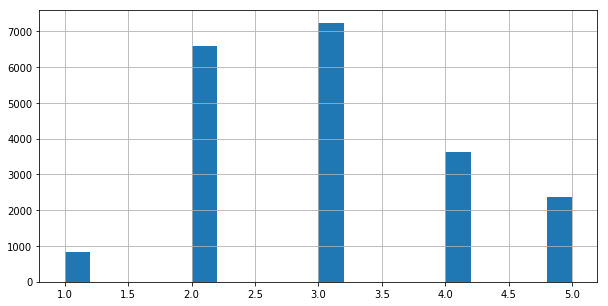

In [29]:
%matplotlib inline 
import matplotlib.pyplot as plt

housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
housing["income_cat"].hist(bins=20, figsize=(10,5))
plt.show()

Now we can do stratified sampling based on the income category using *Scikit-Learn’s StratifiedShuffleSplit* class

In [40]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

Now you should remove the income_cat attribute so the data is back to its original state:

In [41]:
strat_train_set.head()
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

<a id="3c_visualize_data"></a>
## 3.C Discover and Visualize the Data to Gain Insights

Let’s create a copy so you can play with it without harming the training set, as we are going to work directly with it:

In [42]:
housing = strat_train_set.copy()

### Visualizing Geo Data

Since there is geographical information (latitude and longitude), it is a good idea to create a scatterplot of all districts to visualize the data

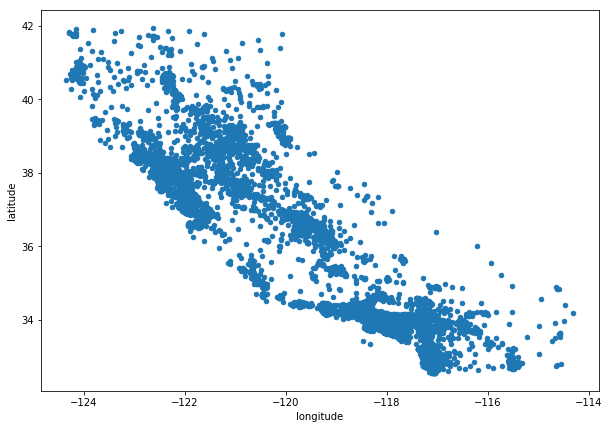

In [68]:
housing.plot(kind="scatter", x="longitude", y="latitude",  figsize=(10,7))

Setting the alpha option to 0.1 makes it much easier to visualize the places where there is a high density of data points 

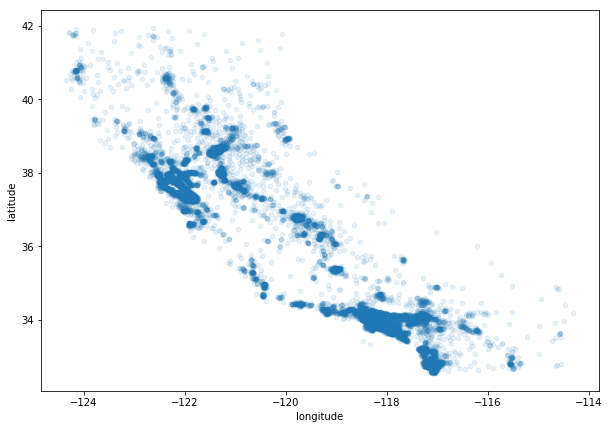

In [67]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1, figsize=(10,7))

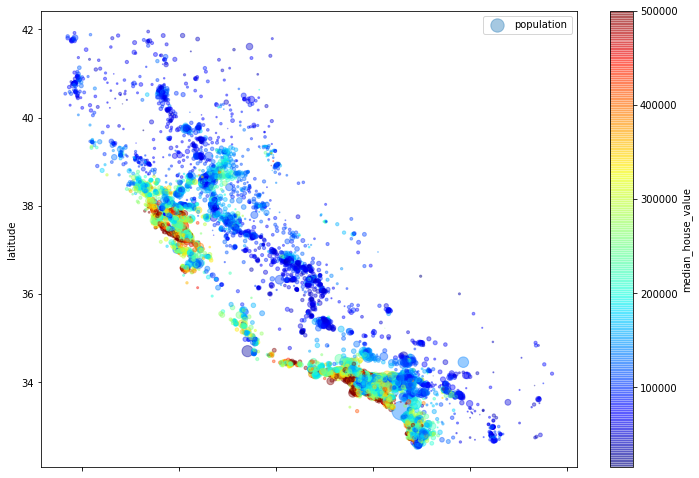

In [71]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(12,8.4),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()